<a href="https://colab.research.google.com/github/AlenZhang-Dev/Learning-Records/blob/master/Machine%20Learning/Deep%20Learning%20with%20Python/3.6%20%E6%B3%A2%E5%A3%AB%E9%A1%BF%E6%88%BF%E4%BB%B7%E3%80%90%E5%9B%9E%E5%BD%92%E9%97%AE%E9%A2%98%E3%80%91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # 预测波士顿房价


不要把回归问题与logistic回归混为一谈。回归问题是常见的机器学习问题，预测一个连续值而不是离散标签。

## 数据集
本节预测20世纪70年代中期波士顿郊区房屋价格中位数，已知当时郊区的一些数据点，比如犯罪率、当地房产税率等。本节用到的数据相对较少，只有506个，分为404个训练样本和102个测试样本。输入数据的每个特征（比如犯罪率）都有不同的取值范围。比如，有些特性是比例，取值范围0-1，有些取值范围1-12，有些取值范围0-100，等

In [1]:
# 加载数据
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

## 准备数据

将取值范围很大的数据输入到神经网络中，会增加网络训练的难度。对于回归问题的数据处理可以参考  [Machine Learning Week2](https://github.com/AlenZhang-Dev/MachineLearning-Stanford/blob/master/Week2/ClassNote-Week2.md)
对于这种数据，一般对每个特征进行标准化，即对于输入数据的每个特征，减去特征平均值，在除上标准差，这样得到的特征平均值为0，标准差为1.使用Numpy很容易可以实现标准化。

需要注意的是，用于测试数据标准化的均值都是在训练数据上得到的，不能使用测试数据的任何结果。

In [2]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

## 构建网络
样本数据很少，所以使用一个小网络，包含两个隐藏层，每层64个单元。一般来说训练数据越少，过拟合越严重，因此使用较小的网络可以降低过拟合。

In [3]:
from keras import models
from keras import layers

def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

编译网络用的是mse损失函数，即均方误差（MSE，mean squared error）。预测值与目标之差的平方。这是回归问题常用的损失函数。

还增加了一个监控新指标：平均绝对误差（MAE，mean absolute error)。预测值与目标值之间的差的绝对值。MAE = 0.5，表示你预测房价与实际价格差为0.5。

网络的最后一层只有一个单元，没有激活，是一个线性层。这是标量回归的典型设置。添加激活函数会限制输出范围。比如，最后一层添加sigmoid激活函数，网络只能学会预测0-1范围内的值。这里最后一层是纯线性的，因此可以学到任何值。

## 使用K折验证你的方法
按照3.4 和3.5的验证方法。由于验证数据点很少，验证集也很少。因此验证分数可能会有很大波动，这取决于你所选择的验证集和训练集。即：验证集的划分方式可能会造成验证分数上有很大的方差，无法对模型进行可靠的评估。

在这种情况下，最佳做法是使用**K折交叉验证**。这种方法将可用数据划分为K个分区（K一般取4或5），实例化K个相同模型，将每个模型在K-1个分区上训练，并在剩下的一个分区上进行评估。模型的验证分数等于K个验证分数的平均值。


In [4]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [5]:
all_scores

[2.6380398273468018, 2.521239995956421, 2.6075634956359863, 2.78279972076416]

在K折交叉验证中，平均数是比单一分数更可靠的指标。

In [6]:
np.mean(all_scores)

2.6374107599258423

提升训练轮次为500次。为了记录模型在每一轮的表现，做一点改动保存每轮验证次数。

In [7]:
#from keras import backend as K

# Some memory clean-up
#K.clear_session()
model.compile('sgd', metrics=['mean_absolute_error'])

In [8]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


计算每一轮中K折验证分数的平均值

In [9]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

绘制验证分数

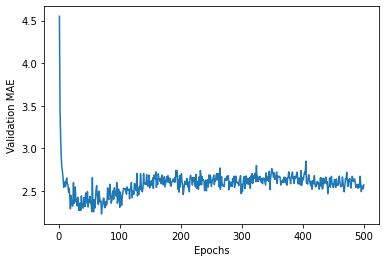

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

因为纵轴的范围较大，数据方差相对较大，，很难看出图的规律，我们重新绘制一张图。
* 删除前10个数据点，因为他们的取值范围与曲线上的其他点不同。
* 将每个数据点替换为前面数据点的指数移动平均值。

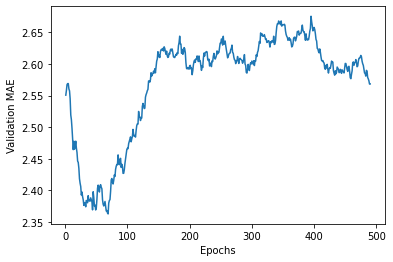

In [11]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## 训练最终模型

In [12]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 18.4629 - mae: 2.7900


In [13]:
test_mae_score

2.790027379989624

## 小结
* 回归问题使用损失函数与分类问题不同。回归常用的损失函数是均方误差（MSE）
* 回归问题使用的评估指标与分类问题不同。显而易见，精度概念不适用于回归问题。常见的回归指标是平均绝对误差（MAE）
* 如果输入数据的特征具有不同的取值范围，应该进行预处理，对每个特征单独进行缩放。
* 如果可用数据很少，使用K折验证评估模型。
* 如果可用的训练数据很少，最好使用隐藏层较小的小型网络，以避免严重的过拟合。